In [ ]:
!pip install datasets
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 req

# Create_augmentations.py

In [ ]:
import os.path

import pandas as pd
import random
from datasets import Dataset, DatasetDict
import torch
import re


def random_replace(string, default_prob):
    replacements = {
        'א': [('ע', default_prob), ('ה', default_prob)],
        'ע': [('א', default_prob), ('ה', default_prob)],
        'ה': [('א', default_prob), ('ע', default_prob)],

        'ט': [('ת', default_prob)],
        'ת': [('ט', default_prob)],

        'ח': [('כ', default_prob)],
        'כ': [('ח', default_prob), ('ק', default_prob)],
        'ק': [('כ', default_prob)],

        'ש': [('ס', default_prob / 2)],
        'ס': [('ש', default_prob / 2)],

        'ב': [('ו', default_prob / 4)],
        'ו': [('ב', default_prob / 4)],

        'לא ': ('לו ', default_prob),
        'לו ': [('לא ', default_prob)]
    }

    # Convert string to list to make replacements
    string_list = list(string)
    for idx, char in enumerate(string_list):
        if char in replacements:
            for replacement, prob in replacements[char]:
                if random.random() < prob:  # Unique probability for each replacement
                    string_list[idx] = replacement
                    break  # Stop after the first replacement
    return ''.join(string_list)


def create_augmentations(percentage=30, verbose=False, is_wiki=False):
    default_prob = float(percentage) / 100
    wiki_name = ""
    if is_wiki:
        wiki_name = "_wiki"

    # input_txt_path = 'hebrew_text' + wiki_name + '.txt'
    input_txt_path = 'hebrew_text.txt'
    output_path = 'hebrew_text_aug_' + str(percentage)

    # Read the input TXT file
    with open(input_txt_path, 'r', encoding='utf-8') as infile:
        lines = infile.readlines()

    # Process each line
    processed_lines = []
    for line in lines:
        line = line.strip()
        modified_line = random_replace(line, default_prob)
        if line == '' or len(line) <= 2:
            continue
        processed_lines.append(f"{line}\t{modified_line}")

    if 'wiki' in input_txt_path:
      # Keep only the strings with at least one hebrew letter in them
      pattern = re.compile(r'[א-ת]')
      processed_lines = [s for s in processed_lines if pattern.search(s)]
      # Remove strings with English letters
      pattern = re.compile(r'[a-zA-Z]')
      processed_lines = [s for s in processed_lines if not pattern.search(s)]

    if verbose:
        print(f'-----------> Example:\n\n')
        print(processed_lines[1])
        print(f'<-----------= Example:\n\n')

    # Save data in txt format - uncomment to activate
    # # Write the original and modified text to the output TXT file
    # output_txt_path = output_path + '.txt'
    # with open(output_txt_path, 'w', encoding='utf-8') as outfile:
    #     outfile.write('\n'.join(processed_lines))
    #
    # print(f"Modified data saved to {output_txt_path}")

    print(f'\nExporting the data to Excel file')

    processed_lines = processed_lines[1:]
    data = [line.strip().split('\t') for line in processed_lines]
    if 'wiki' in input_txt_path:
        df = pd.DataFrame(data)
        df.columns = ['original', 'errors'] + df.columns[2:].tolist()
    else:
        df = pd.DataFrame(data, columns=['original', 'errors'])  # Adjust column names as needed
    excel_output_path = output_path + '.xlsx'
    df.to_excel(excel_output_path, index=False, engine='openpyxl')

    print(f"Conversion complete. Check {excel_output_path}")
    return excel_output_path


def export_dataset(excel_path):
    df = pd.read_excel(excel_path)
    df.dropna(subset=['errors', 'original'], inplace=True)
    texts_with_errors = df['errors'].tolist()
    texts_corrected = df['original'].tolist()

    data_dict = {
        'errors': texts_with_errors,
        'original': texts_corrected
    }

    # dataset = ds.Dataset.from_dict(data_dict)
    dataset = Dataset.from_dict(data_dict)

    return dataset


def export_train_test_dataset(excel_path, test_size=0.2):
    if (not os.path.exists('train.pt')) and (not os.path.exists('test.pt')):
        dataset = export_dataset(excel_path)
        # Split the dataset into training and testing sets
        train_test_split = dataset.train_test_split(test_size=test_size)
        torch.save(train_test_split['train'], 'train.pt')
        torch.save(train_test_split['test'], 'test.pt')

        return train_test_split['train'], train_test_split['test']
    else:
        train_split = torch.load('train.pt')
        test_split = torch.load('test.pt')
        return train_split, test_split



def full_run(percentage=30, verbose=False):
    return export_dataset(create_augmentations(percentage, verbose))


def full_run_train_test_split(percentage=30, verbose=True):
    return export_train_test_dataset(create_augmentations(percentage, verbose))


full_run_train_test_split()


-----------> Example:


אחרי שאמות יבואו פתאום אנשים בלי בושה עם חיבוק פולני אחרי שאמות יספרו בחלון בדיחות עתיקות ישפילו פנים אחרי שאמות יגיעו אישית זרים עם זרים ישירו שירים אחרי שאמות בקול חרישי תשטוף הרכילות את הבור הטרי אני אפתח בקבוק עם כמה ממחטות נייר אזמין אותם לפיקניק בירקון המצויר אפרוס מפה עם ריבועים אמרח כמה כריכים אכין להם בדיוק כאילו מה שהם צריכים כאילו מה שהם צריכים אחרי שאמות ירדו קצת טיפות מישהו יפלוט השמיים בוכים אחרי שאמות ישימו כיפות כמה שטרות בין זרי הפרחים אחרי שאמות הכול יישאר ממש כשהיה פה מאז מעולם אחרי שאשוט אשתקף בירקון לעוד רבע שנייה אזרום אל הים	הכרי שאמוט יבועב פטעום הנשים בלי בוסה עם כיבוק פולני החרי שעמות יספרו בחלבן בדיחות עתיכות ישפילו פנים אחרי שהמוט יגיאו אישיט זרים עם זרים ישירו שירים עכרי סעמות בכבל חרישי תשתוף הרכילוט הת אבור הטרי אני אפתח בכבוק אם כמה ממכטוט נייר הזמין אוטם לפיכניק בירקון המצויר אפרוס מפא הם ריבואים עמרכ חמע כריכים אכין להם בדיוק קאילו מה שאם צריכים חאילו מא שהם צריחים אחרי שהמוט ירדו קצת תיפוט מישהו יפלות השמיים בוחים הכרי שאמוט יש

(Dataset({
     features: ['errors', 'original'],
     num_rows: 11634
 }),
 Dataset({
     features: ['errors', 'original'],
     num_rows: 2909
 }))

# transformer_prepare_data.py

In [ ]:
import pandas as pd
from datasets import Dataset
# import tensorflow as tf
# from create_augmentations import *
from transformers import BertTokenizer, BatchEncoding, T5Tokenizer, T5ForConditionalGeneration, MT5Tokenizer, MT5ForConditionalGeneration
from datasets import load_from_disk
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from transformers import BertForSequenceClassification
from sklearn.preprocessing import LabelEncoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

X_NAME = 'errors'  # Todo: change names
Y_NAME = 'original'

# ---------- HYPERPARAMETERS -----------
# -------------------------------------->
max_length = 128
# <--------------------------------------


# --------- HELPER FUNCTIONS -----------
# -------------------------------------->
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items() if key in ['input_ids', 'attention_mask']}
        # Ensure labels are correctly indexed
        if isinstance(self.labels, BatchEncoding):
            item['labels'] = self.labels['input_ids'][idx]  # Adjust according to how labels are stored
        else:
            item['labels'] = self.labels[idx].clone().detach()

        return item

    def __len__(self):
        # return len(self.labels)
        return len(self.encodings['input_ids'])


class Seq2SeqDataset(Dataset):
    def __init__(self, inputs, targets, tokenizer, max_length=128):
        self.inputs = inputs
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        print(f"Index: {idx}, Type: {type(idx)}")
        if isinstance(idx, list):
            raise ValueError("Index must be an integer, not a list")

        input_text = self.inputs[idx]
        target_text = self.targets[idx]

        input_encoding = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        target_encoding = self.tokenizer(
            target_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': input_encoding['input_ids'].squeeze(),
            'attention_mask': input_encoding['attention_mask'].squeeze(),
            'labels': target_encoding['input_ids'].squeeze()
        }

# <--------------------------------------


def get_model():
    # model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased')
    # tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
    # model = T5ForConditionalGeneration.from_pretrained('t5-small')
    # tokenizer = T5Tokenizer.from_pretrained('t5-small')

    model_name = "google/mt5-small"
    tokenizer = MT5Tokenizer.from_pretrained(model_name)
    model = MT5ForConditionalGeneration.from_pretrained(model_name)


    # --------- FREEZING LAYERS ------------
    # -------------------------------------->

    # for name, param in model.named_parameters():
    #     if name.startswith("encoder.block.2."):
    #         param.requires_grad = False

    # for name, param in model.named_parameters():
    #     if name.startswith("encoder.block.3."):
    #         param.requires_grad = False

    # for name, param in model.named_parameters():
    #     if name.startswith("encoder.block.4."):
    #         param.requires_grad = False

    for name, param in model.named_parameters():
        if name.startswith("encoder.block.5."):
            param.requires_grad = False

    for name, param in model.named_parameters():
        if name.startswith("encoder.block.6."):
            param.requires_grad = False

    for name, param in model.named_parameters():
        if name.startswith("encoder.block.7."):
            param.requires_grad = False

    for name, param in model.named_parameters():
        if name.startswith("decoder.block.0."):
            param.requires_grad = False

    for name, param in model.named_parameters():
        if name.startswith("decoder.block.1."):
            param.requires_grad = False

    for name, param in model.named_parameters():
        if name.startswith("decoder.block.2."):
            param.requires_grad = False

    for name, param in model.named_parameters():
        if name.startswith("decoder.block.3."):
            param.requires_grad = False

    for name, param in model.named_parameters():
        if name.startswith("decoder.block.4."):
            param.requires_grad = False

    for name, param in model.named_parameters():
        if name.startswith("decoder.block.5."):
            param.requires_grad = False

    # for name, param in model.named_parameters():
    #     if name.startswith("decoder.block.6."):
    #         param.requires_grad = False

    # <--------------------------------------

    # ----------SEEING THE MODEL------------
    # -------------------------------------->
    print('Printing the layers of the model')
    for name, param in model.named_parameters():
        print(name, param.requires_grad)
    # <--------------------------------------
    return model, tokenizer


def prepare_data(tokenizer, low_mem=True):
    # -------------- DATASET ---------------
    # -------------------------------------->
    dataset_train, dataset_test = full_run_train_test_split(verbose=False)
    dataset_train.set_format('pytorch')
    dataset_test.set_format('pytorch')
    train_inputs = dataset_train[X_NAME]
    train_labels = dataset_train[Y_NAME]
    test_inputs = dataset_test[X_NAME]
    test_labels = dataset_test[Y_NAME]

    if low_mem:
      print(f'\nMaking the sets smaller due to low available memory\n')
      train_inputs = train_inputs[2000:2500]
      train_labels = train_labels[2000:2500]
      test_inputs = test_inputs[:200]
      test_labels = test_labels[:200]


    def truncate_sentences(sentences, sentences_target):
        truncated_sentences = []
        truncated_sentences_targets = []
        for sentence, label in zip(sentences, sentences_target):
            words = sentence.split()
            labels = label.split()
            num_words = random.randint(1, 13)  # Random number between 1 and 13
            truncated_sentence = ' '.join(words[:num_words])
            truncated_sentence_target = ' '.join(labels[:num_words])
            truncated_sentences.append(truncated_sentence)
            truncated_sentences_targets.append(truncated_sentence_target)
        print('----------------------')
        print('Data after truncation:')
        print(f'truncated input:\n{truncated_sentences[1]}')
        print(f'truncated label:\n{truncated_sentences_targets[1]}')
        print('----------------------')
        return truncated_sentences, truncated_sentences_targets

    train_inputs, train_labels = truncate_sentences(train_inputs, train_labels)
    test_inputs, test_labels = truncate_sentences(test_inputs, test_labels)

    train_input_tokenized = tokenizer(train_inputs, truncation=True, padding=True, max_length=max_length, return_tensors='pt')
    train_labels_tokenized = tokenizer(train_labels, truncation=True, padding=True, max_length=max_length, return_tensors='pt').input_ids
    test_input_tokenized = tokenizer(test_inputs, truncation=True, padding=True, max_length=max_length, return_tensors='pt')
    test_labels_tokenized = tokenizer(test_labels, truncation=True, padding=True, max_length=max_length, return_tensors='pt').input_ids

    text_tensor_train_ds = TextDataset(train_input_tokenized, train_labels_tokenized)
    text_tensor_test_ds = TextDataset(test_input_tokenized, test_labels_tokenized)

    # text_tensor_train_ds = Seq2SeqDataset(train_input_tokenized, train_labels_tokenized, tokenizer, max_length=128)
    # text_tensor_test_ds = Seq2SeqDataset(test_input_tokenized, test_labels_tokenized, tokenizer, max_length=128)

    # Save the datasets to disk
    # torch.save(text_tensor_train_ds, 'tokenized/text_tensor_train_ds.pt')
    # torch.save(text_tensor_test_ds, 'tokenized/text_tensor_test_ds.pt')
    return text_tensor_train_ds, text_tensor_test_ds


def get_model_and_data(path_to_data='tokenized', low_mem=True):
    model, tokenizer = get_model()
    # prepare_data(tokenizer)  # todo: remove this line
    text_tensor_train_ds, text_tensor_test_ds = prepare_data(tokenizer, low_mem)

    return model, tokenizer, text_tensor_train_ds, text_tensor_test_ds




# transformer.py

In [ ]:
# import pandas as pd
# from datasets import Dataset
# from create_augmentations import *
# from datasets import load_from_disk
# import os
# import torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from transformers import BertForSequenceClassification
# from sklearn.preprocessing import LabelEncoder
# from transformers import BertTokenizer, TrainingArguments, Trainer, BatchEncoding, TrainerCallback
# from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
# import torch
# from transformer_prepare_data import *
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm.auto import tqdm
import evaluate
from torch.optim.lr_scheduler import ChainedScheduler, ExponentialLR


# ---------- HYPERPARAMETERS -----------
# -------------------------------------->
BATCH_SIZE = 16
num_epochs = 15
# <--------------------------------------


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Load the saved datasets
model, tokenizer, text_tensor_train_ds, text_tensor_test_ds = get_model_and_data(low_mem=False)
# text_tensor_train_ds = torch.load('tokenized/text_tensor_train_ds.pt')
# text_tensor_test_ds = torch.load('tokenized/text_tensor_test_ds.pt')


def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}


train_dataloader = DataLoader(text_tensor_train_ds, shuffle=True, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(text_tensor_test_ds, batch_size=BATCH_SIZE)

num_training_steps = num_epochs * len(train_dataloader)

optimizer = AdamW(model.parameters(), lr=5e-3, weight_decay=0.01)

from transformers import get_cosine_schedule_with_warmup

cosine_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=num_training_steps
)


# Exponential decay scheduler
exp_scheduler = ExponentialLR(optimizer, gamma=0.9)

# Chain the schedulers together
lr_scheduler = ChainedScheduler([cosine_scheduler, exp_scheduler])


model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Printing the layers of the model
shared.weight True
encoder.block.0.layer.0.SelfAttention.q.weight True
encoder.block.0.layer.0.SelfAttention.k.weight True
encoder.block.0.layer.0.SelfAttention.v.weight True
encoder.block.0.layer.0.SelfAttention.o.weight True
encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight True
encoder.block.0.layer.0.layer_norm.weight True
encoder.block.0.layer.1.DenseReluDense.wi_0.weight True
encoder.block.0.layer.1.DenseReluDense.wi_1.weight True
encoder.block.0.layer.1.DenseReluDense.wo.weight True
encoder.block.0.layer.1.layer_norm.weight True
encoder.block.1.layer.0.SelfAttention.q.weight True
encoder.block.1.layer.0.SelfAttention.k.weight True
encoder.block.1.layer.0.SelfAttention.v.weight True
encoder.block.1.layer.0.SelfAttention.o.weight True
encoder.block.1.layer.0.layer_norm.weight True
encoder.block.1.layer.1.DenseReluDense.wi_0.weight True
encoder.block.1.layer.1.DenseReluDense.wi_1.weight True
encoder.block.1.layer.1.DenseReluDense.

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 512)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 512)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
          

In [5]:
import numpy as np
from google.colab import files
progress_bar = tqdm(range(num_training_steps))

def calc_accuracy(model, tokenizer, test_dataloader):
    metric = evaluate.load("accuracy")
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_examples = 0

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for batch in test_dataloader:
            batch = {key: value.to(device) for key, value in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()

            # Generate predictions
            generated_tokens = model.generate(batch['input_ids'], max_length=batch['labels'].shape[1])

            # Decode the generated tokens and labels to text
            generated_texts = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
            labels_texts = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)

            # Calculate accuracy by comparing generated texts to target texts
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            predictions = predictions.view(-1)
            references = batch["labels"].view(-1)
            mask = references != tokenizer.pad_token_id
            predictions = predictions[mask]
            references = references[mask]

            metric.add_batch(predictions=predictions, references=references)

    avg_test_loss = total_loss / len(test_dataloader)
    accuracy_dict = metric.compute()
    accuracy = float(accuracy_dict['accuracy'])
    random_index = random.randint(0, len(labels_texts) - 1)
    print(f'Current state:\nTarget: {labels_texts[random_index]}\nPrediction: {generated_texts[random_index]}')

    model.train()  # Set the model back to training mode
    return avg_test_loss, accuracy


model.train()
train_losses = []
test_losses = []
test_accuracies = []
best_accuracy = np.inf

for epoch in range(num_epochs):
    epoch_loss = 0
    for batch in train_dataloader:
        batch = {key: value.to(device) for key, value in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        epoch_loss += loss.item()  # Accumulate the loss

    # Calculate average loss for the epoch
    avg_train_loss = epoch_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"\nEpoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}")

    # -------------------------------------------
    model.eval()
    avg_test_loss, accuracy = calc_accuracy(model, tokenizer, test_dataloader)
    test_losses.append(avg_test_loss)
    test_accuracies.append(accuracy)
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.4f}  learning reate: {optimizer.param_groups[0]['lr']}")
    # Set the model back to training mode
    model.train()
    # -------------------------------------------

    # Saving checkout
    if accuracy < best_accuracy:
      best_accuracy = accuracy
      torch.save(model.state_dict(), 'saved_model_checkout.pth')
      files.download('saved_model_checkout.pth')



torch.save(model.state_dict(), 'saved_model.pth')



  0%|          | 0/10920 [00:00<?, ?it/s]


Epoch 1/15, Training Loss: 4.0446


Current state:
Target: בין עצי היער
Prediction: 
Test Loss: 2.5449, Test Accuracy: 0.1056  learning reate: 0.004462699606126046

Epoch 2/15, Training Loss: 1.9585
Current state:
Target: אמרתי לך תזהרי סכנה זה יגמר
Prediction: אני אני אני אני אני אני אני אני אני אני אני אני אני אני אני אני
Test Loss: 2.4024, Test Accuracy: 0.1303  learning reate: 0.00432785286529723

Epoch 3/15, Training Loss: 1.8260
Current state:
Target: אמרתי לך תזהרי סכנה זה יגמר
Prediction: אני אני אני אני אני אני אני אני אני אני אני אני אני אני אני אני
Test Loss: 2.0620, Test Accuracy: 0.1807  learning reate: 0.004100513912101705

Epoch 4/15, Training Loss: 1.6168
Current state:
Target: יצאתי
Prediction: אם
Test Loss: 1.8983, Test Accuracy: 0.2157  learning reate: 0.0037908023671773703

Epoch 5/15, Training Loss: 1.4922
Current state:
Target: כבר ירד השלג בהרים רחוקים בשלג אנו צועדים כי בתוך היער האפל
Prediction: אני אני אני אני אני אני אני אני אני אני אני אני אני אני אני אני
Test Loss: 1.8369, Test Accuracy: 0.22

  0%|          | 0/182 [00:00<?, ?it/s]


Accuracy: {'accuracy': 0.7797559090163743}


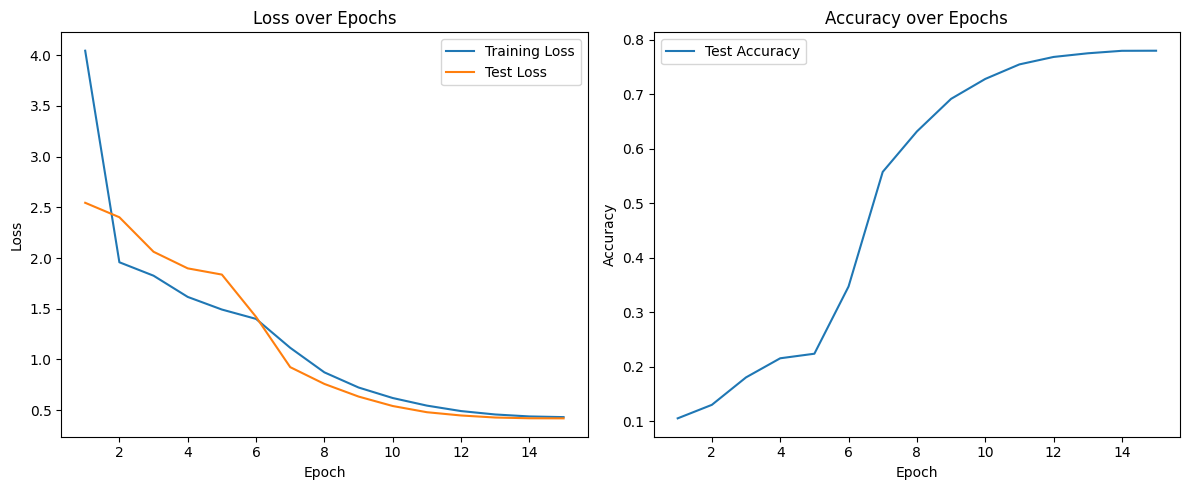

In [6]:
import matplotlib.pyplot as plt

num_testing_steps = len(test_dataloader)
progress_bar_test = tqdm(range(num_testing_steps))


metric = evaluate.load("accuracy")
model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    # metric.add_batch(predictions=predictions, references=batch["labels"])

    # Flatten predictions and references
    predictions = predictions.view(-1)
    references = batch["labels"].view(-1)

    # Filter out padding tokens (if applicable)
    mask = references != tokenizer.pad_token_id
    predictions = predictions[mask]
    references = references[mask]

    metric.add_batch(predictions=predictions, references=references)
    progress_bar_test.update(1)


# Compute the final accuracy
final_score = metric.compute()
print("\nAccuracy:", final_score)


# Plotting the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot training and test loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Checking the trained model
### check_model.py

In [22]:
import torch
# from transformers import T5Tokenizer, T5ForConditionalGeneration
# from transformer_prepare_data import *

# model, tokenizer = get_model_and_data()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Sample data for inference
new_data = ["זה למשל דוגמא אם שגיעה", "עוד טקסט לטיקון", "הנה טאות", "לא הני"]
new_data_tokenized = tokenizer(
    new_data, max_length=128, padding='max_length', truncation=True, return_tensors='pt'
)

# Move data to device
input_ids = new_data_tokenized['input_ids'].to(device)
attention_mask = new_data_tokenized['attention_mask'].to(device)
# print("Tokenized Input IDs:", input_ids)
# print("Attention Mask:", attention_mask)

# model.load_state_dict(torch.load('spellcheck_model/saved_model.pth'))
model.eval()

with torch.no_grad():
    generated_ids = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=128,
        num_beams=4,
        early_stopping=True
    )


predictions = [tokenizer.decode(g, skip_special_tokens=True) for g in generated_ids]
print("Predictions:")
for i, pred in enumerate(predictions):
    print(f"Input: {new_data[i]}")
    print(f"Output: {pred}")
    print()



Predictions:
Input: זה למשל דוגמא אם שגיעה
Output: זה למשל דוגמא עם שגיעה

Input: עוד טקסט לטיקון
Output: עוד טקסט לתיקון

Input: הנה טאות
Output: הנה טעות

Input: לא הני
Output: לא אני



# Sanity check that the used tokenizer works

In [8]:
# predictions = [tokenizer.decode(g, skip_special_tokens=True) for g in generated_ids]
input = "שגיאה"
input_encoded = tokenizer.encode(input)
input_decoded = tokenizer.decode(input_encoded, skip_special_tokens=True)

print(f'input: {input}')
print(f'input_encoded: {input_encoded}')
print(f'input_decoded: {input_decoded}')

input: שגיאה
input_encoded: [83407, 49491, 1]
input_decoded: שגיאה


In [10]:
from google.colab import files

# files.download('saved_model_checkout.pth')
files.download('saved_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
# from google.colab import drive
# drive.mount('/content/drive')

# # Save the model to your Google Drive
# torch.save(model.state_dict(), '/content/drive/My Drive/saved_model.pth')
